# Challenge Large Scale Machine Learning

## Fusion of algorithms for face recognition
The increasingly ubiquitous presence of biometric solutions and face recognition in particular in everyday life requires their adaptation for practical scenario. In the presence of several possible solutions, and if global decisions are to be made, each such single solution can be far less efficient than tailoring them to the complexity of an image.

In this challenge, the goal is to build a fusion of algorithms in order to construct the best suited solution for comparison of a pair of images. This fusion will be driven by qualities computed on each image.

Comparing of two images is done in two steps. 1st, a vector of features is computed for each image. 2nd, a simple function produces a vector of scores for a pair of images. The goal is to create a function that will compare a pair of images based on the information mentioned above, and decide whether two images belong to the same person.

You are provided a label set of training data and a test set without labels. You should submit a .csv file with labels for each entry of this test set.

## The properties of the dataset
**Training data:**

The training set consist of two files, xtrain_challenge.csv and xtest_challenge.csv.

File **xtrain_challenge.csv** contains one observation per row which contains following entries based on a pair of images:
- columns 1-13 - 13 qualities on first image
- columns 14-26 - 13 qualities on second image
- columns 27-37 - 11 matching scores between the two images.

File **ytrain_challenge.csv** contains one line with each entry corresponding to one observation in xtrain_challenge.csv, maintaining the order, and has '1' if a pair of images belong to the same person and '0' otherwise.

For each of these 38 variables, there are in total 9,800,713 training observations.



**Test data:**

File xtest_challenge.csv has the same structure as file xtrain_challenge.csv.

There are in total 3,768,311 test observations.

## The performance criterion
Consider the problem of the supervised classification with two classes labeled '0' and '1'. Many methods for supervised classification assign a new observation x to a class using the following rule:

g(x)={1 if f(x)≥t, 0 otherwise

Threshold t is then chosen due to specific needs managing the trade-off between the true positive rate (TPR) and the false positive rate (FPR), depending on the cost of the corresponding mistakes.

Here, the performance criterion is TPR for the value of FPR = 10-4, or, speaking in other words, one needs to maximize the value of the receiver operating characteristic (ROC) in the point FPR = 10−4. The submitted solution file should thus contain the score for each observation.

**Training Data**
- Training data, input (file xtrain_challenge.csv): https://www.dropbox.com/s/618rb0wev4q84kj/xtrain_challenge.csv
- Training data, output (file ytrain_challenge.csv):
https://www.dropbox.com/s/oph3w9sn3nmu376/ytrain_challenge.csv

**Test Data**
Test data, input (file xtest_challenge.csv): https://www.dropbox.com/s/fezxb6lrzass556/xtest_challenge.csv

### Imports and install

In [0]:
!pip install -q vecstack

In [0]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 17662547565417735446, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 13074107072940700753
 physical_device_desc: "device: XLA_CPU device", name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 8050722398930612734
 physical_device_desc: "device: XLA_GPU device", name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 15956161332
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 16724893946207099056
 physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"]

In [0]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

TensorFlow is already loaded. Please restart the runtime to change versions.
Found GPU at: /device:GPU:0


In [0]:
%matplotlib inline
import numpy as np
import pandas as pd
import sys
import os
import matplotlib.pyplot as plt
import math
from sklearn.linear_model import LogisticRegression
import lightgbm as lgb
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from vecstack import stacking
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import pickle
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder

### Load and investigate the data

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# Load training data
xtrain = pd.read_csv('/content/drive/My Drive/data challenge_idemia/xtrain_challenge.csv', delimiter=',')

In [0]:
ytrain = pd.read_csv('/content/drive/My Drive/data challenge_idemia/ytrain_challenge.csv', delimiter=',')

In [0]:
# Load testing data
xtest = pd.read_csv('/content/drive/My Drive/data challenge_idemia/xtest_challenge.csv', delimiter=',')

In [0]:
print(xtrain.shape)
print(ytrain.shape)

(9800713, 37)
(9800713, 1)


In [0]:
# Drop duplicates
xtrain.drop_duplicates()
xtest.drop_duplicates()
print(len(xtrain))
print(len(xtest))

9800713
3768311


In [0]:
# Concatenation of train data and label
data = pd.concat([xtrain,ytrain], axis=1)
data.head()

,qs1,qs2,qs3,qs4,qs5,qs6,qs7,qs8,qs9,qs10,qs11,qs12,qs13,qr1,qr2,qr3,qr4,qr5,qr6,qr7,qr8,qr9,qr10,qr11,qr12,qr13,s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,s11,y
0,1.0,0.0,0.0,-6.24,-5.27,-1.86,0.63,3.27,0.89,350.98,64.86,0.0,1.00,1.0,0.0,0.0,-9.44,-12.53,0.84,2.59,1.53,1.03,276.02,58.02,0.0,1.00,2405.94,1981.09,2677.84,2470.44,1579.39,2185.79,2118.77,2580.99,2498.04,3180.58,2718.29,0
1,1.0,0.0,0.0,-0.42,-4.50,-4.31,1.61,1.72,2.76,347.06,28.85,0.0,0.99,1.0,0.0,0.0,-0.35,-18.97,-1.31,1.23,0.84,0.34,263.84,30.50,0.0,1.00,3241.37,2015.24,3987.19,3343.53,2894.69,2947.34,2689.42,3763.51,2544.22,3515.58,3247.49,0
2,1.0,0.0,0.0,33.76,-19.29,2.71,1.73,1.32,1.53,135.94,57.65,1.0,0.01,1.0,0.0,0.0,-12.58,-9.99,-0.15,1.21,0.34,1.60,357.67,51.98,1.0,1.00,2199.22,2549.59,2164.41,2100.69,1294.35,2136.04,1644.05,2308.05,1774.88,3005.79,2507.02,0
3,1.0,0.0,0.0,-2.82,-8.04,3.04,0.94,2.92,0.09,288.07,21.23,0.0,0.94,1.0,0.0,0.0,1.57,-13.22,-2.66,1.18,0.23,0.38,268.44,24.59,0.0,0.19,2390.40,2141.75,2086.02,2154.69,1247.48,1903.36,2232.54,2146.34,2201.53,3315.03,2274.76,0
4,1.0,0.0,0.0,3.56,-10.61,-0.65,0.19,1.04,2.10,166.12,37.36,1.0,0.00,1.0,0.0,0.0,20.03,-15.53,-1.21,1.31,0.23,1.25,172.19,26.14,0.0,1.00,1822.14,2202.60,2150.07,2194.25,1575.43,2345.59,1976.82,1440.78,2061.06,2927.96,2073.16,0


In [0]:
# Similarity matching between both images (similar if y = 1, otherwise 0)
match = (ytrain == 1)
print('Number of matches = {}'.format( match.sum()[0]))

Number of matches = 673052


In [0]:
# Number of common same images between train & test sets (comparison of features)
Xtr = xtrain.copy()
Xte = xtest.copy()

# Features of image A correspond to qsx and features of the second image B correspond to columns qrx
# x varies from 1 to 13

Xtr["featA"] = Xtr["qs1"].astype("str")+"_"
Xtr["featB"] = Xtr["qr1"].astype("str")+"_"

Xte["featA"] = Xte["qs1"].astype("str")+"_"
Xte["featB"] = Xte["qr1"].astype("str")+"_"

for i in range(12): 
  qs = "{}{}".format('qs', i+2)
  qr = "{}{}".format('qr', i+2)

  Xtr["featA"] = Xtr["featA"] + Xtr[qs].astype("str")+"_"
  Xtr["featB"] = Xtr["featB"] + Xtr[qr].astype("str")+"_"

  Xte["featA"] = Xte["featA"] + Xte[qs].astype("str")+"_"
  Xte["featB"] = Xte["featB"] + Xte[qr].astype("str")+"_"

# Concatenation of features in columns qsx and qrx for training and for testing

feat_train = pd.concat([Xtr["featA"],Xtr["featB"]], axis = 0)
feat_train.drop_duplicates(inplace=True)

feat_test = pd.concat([Xte["featA"],Xte["featB"]], axis = 0)
feat_test.drop_duplicates(inplace=True)

In [0]:
feat = pd.concat([feat_train, feat_test], axis=0)
feat.drop_duplicates(inplace=True)
print("The number of images: {}".format(feat.shape[0]))
print("The number of images in the training set is: {}".format(feat_train.shape[0]))
print("The number of images in the testing set is: {}".format(feat_test.shape[0]))

In [0]:
print("The number of new images in the testing set is: {}".format(feat.shape[0] - feat_test.shape[0]))

The number of new images in the testing set is: 9274367


In [0]:
# Encoding labels 
enc = LabelEncoder()
enc.fit(feat)

We want to encode the categorical features into model-understandable numerical data, fit and transform the first and second images features. we will call the first image A and second image B and their features respectively A and B.

In [0]:
xtrain_encod["A"] = enc.transform(Xtr["featA"])
xtrain_encod["B"] = enc.transform(Xtr["featB"])

xtest_encod["A"] = enc.transform(Xte["featA"])
xtest_encod["B"] = enc.transform(Xte["featB"])

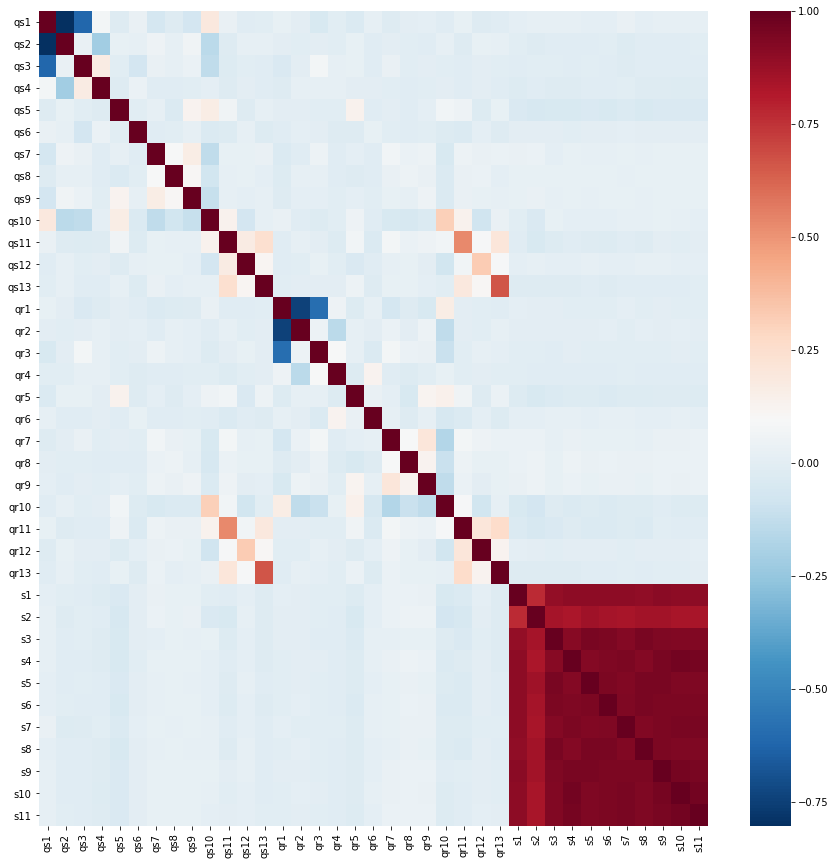

In [0]:
## Correlations
data_corr = np.array(data.sample(10000))
x = pd.DataFrame(data_corr[:,:-1])
x.columns = xtrain.columns
y = pd.DataFrame(data_corr[:,-1])
y.columns = ytrain.columns

corr = x.corr()
plt.figure(figsize=(14,14))
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns, cmap='coolwarm')
plt.show()

We can notice a high correlation between Sx (x from 1 to S11).
There is a high correlation between qr13 and qs13, and between qr11 and qs11.

In [0]:
similarity = x.iloc[:,26:]
sns.set(style="ticks", color_codes=True)
sns.PairGrid(similarity).map_diag(sns.kdeplot, color='Blue', legend=False).map_upper(plt.scatter, edgecolor="w", s=30).map_lower(sns.kdeplot, shade=True,shade_lowest=False, cmap="mako", legend=False)

In [0]:
#Highly correlated values
corr_list = []
threshold = 0.1
size = 10

for i in range(0, size):
    for j in range(i+1, size):
        if (x.corr().iloc[i,j]>= threshold and x.corr().iloc[i,j]<1) or (x.corr().iloc[i,j] > -1 and x.corr().iloc[i,j]<=-threshold):
            corr_list.append([x.corr().iloc[i,j],i,j])

for v,i,j in sorted(corr_list,key= lambda x: -abs(x[0])):
    print("%s and %s = %.2f" % (x.columns[i], x.columns[j], v))

qs1 and qs2 = -0.83
qs1 and qs3 = -0.57
qs2 and qs4 = -0.23
qs1 and qs10 = 0.20
qs3 and qs4 = 0.19
qs7 and qs9 = 0.18
qs5 and qs10 = 0.16
qs2 and qs10 = -0.16
qs7 and qs10 = -0.15
qs3 and qs10 = -0.13
qs5 and qs9 = 0.12
qs8 and qs9 = 0.11
qs9 and qs10 = -0.11
qs8 and qs10 = -0.11
qs7 and qs8 = 0.10


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    2.7s finished


Text(0.5, 1.0, 'Feature importance')

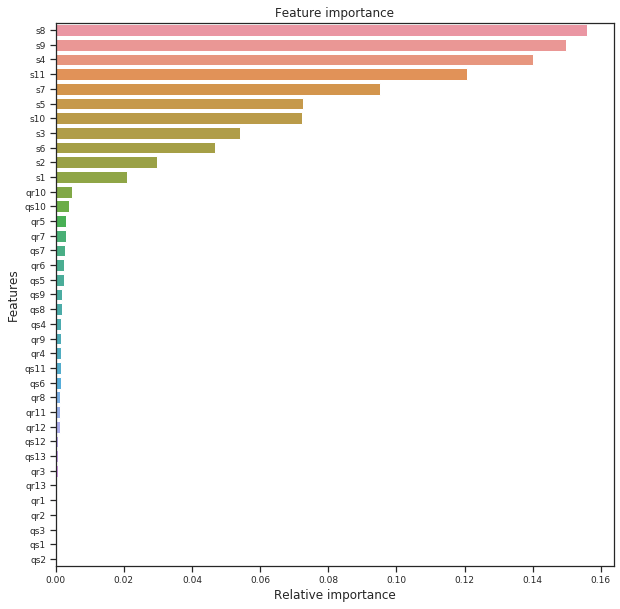

In [0]:
# features importance

rf = RandomForestClassifier(verbose=1)
classifier = rf.fit(x,y)

indices = np.argsort(rf.feature_importances_)[::-1][:40]
plt.figure(figsize=(10,10))

g = sns.barplot(y=x.columns[indices][:40],x = classifier.feature_importances_[indices][:40] , orient='h')
g.set_xlabel("Relative importance",fontsize=12)
g.set_ylabel("Features",fontsize=12)

g.tick_params(labelsize=9)
g.set_title("Feature importance")

We can observe that qr10 qs10 qr5 and qr7 are important features. At this step, even though qs1 and qs2 don't seem important, we can still keep them and take them into account.

### Train a simple classifier

We split our dataset into train and test.

In [0]:
X_train, X_test, y_train, y_test = train_test_split(xtrain, ytrain, test_size=0.2, random_state=42)

Scaling and standardizing can help features arrive in more digestible form for  algorithms like logistic regression and if we have outliers among our features, normalizing our data will help scaling most of the data to a small interval.

In [0]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

### Basic models and their accuracy scores

In [0]:
# random forest
clf = RandomForestClassifier(n_estimators=100, max_depth = 20, random_state=0)
clf.fit(X_train, y_train.values.ravel())
pred = clf.predict_proba(X_test)
pred_rf = np.where(pred[:,1] > 0.5, 1, 0)
accuracy_score(pred_rf, y_test)

0.9975450770683567

In [0]:
# Logistic regression
clf_lr = LogisticRegression(random_state=0, solver='lbfgs', max_iter= 10000, multi_class='auto', verbose=1)
clf_lr.fit(X_train, y_train.values.ravel())
pred_lr = clf_lr.predict(X_test)
acc_lr = accuracy_score(pred_lr, y_test)
print(acc_lr)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.99667


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   17.3s finished


In [0]:
# light gradient boosting model
clf_lgbm = LGBMClassifier(learning_rate = 0.008, num_leaves = 1000, n_estimators=10000)
clf_lgbm.fit(X_train, y_train.values.ravel())

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.008, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=10000, n_jobs=-1, num_leaves=1000, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [0]:
pred_lgbm = clf_lgbm.predict_proba(X_test)

In [0]:
acc_lgbm = accuracy_score(pred_lgbm, y_test)

Light GBM can handle the large size of data and takes lower memory to run than xgboost.

### Stacking / Ensemble methods

Ensemble methods are algorithms that combine several machine learning techniques into one predictive model in order to decrease variance (bagging), bias (boosting), or improve predictions (stacking). In our case, we want to increase the accuracy score and improve even more the predictions.

We will try to combine many models that we have tried separetly by stacking them.
Stacking is an ensemble learning technique that combines multiple classification or regression models via a meta-classifier or a meta-regressor. The base level models are trained based on a complete training set, then the model is trained on the outputs of the base level model as features. The obtained stacked model will then be used passed through an lgbm, which is the most efficient here.

In [0]:
models = [RandomForestClassifier(n_estimators=100, max_depth = 20, random_state=0), 
          LogisticRegression(random_state=0, solver='lbfgs', max_iter= 10000, multi_class='auto', verbose=1),
          KNeighborsClassifier(n_neighbors=5, n_jobs=-1),
          XGBClassifier(random_state=0, n_jobs=-1, learning_rate=0.1, n_estimators=100, max_depth=3),
]

In [0]:
#models = [RandomForestClassifier(n_estimators=100, max_depth = 20, random_state=0), 
#          XGBClassifier(random_state=0, n_jobs=-1, learning_rate=0.1, n_estimators=100, max_depth=3),
#]

In [0]:
S_train, S_test = stacking(models,                   
                           X_train, y_train.values.ravel(), X_test,   
                           regression=False, 
                           mode='oof_pred_bag', 
                           needs_proba=True,
                           save_dir=None, 
                           metric=accuracy_score, 
                           n_folds=4, 
                           stratified=True,
                           shuffle=True,  
                           random_state=42,    
                           verbose=2)

task:         [classification]
n_classes:    [2]
metric:       [accuracy_score]
mode:         [oof_pred_bag]
n_models:     [2]

model  0:     [RandomForestClassifier]


In [0]:
model_final = LGBMClassifier(learning_rate = 0.008, num_leaves = 1000, n_estimators=10000)

model_final = model_final.fit(S_train, y_train)
y_pred = model_final.predict(S_test)
print('Final prediction score: [%.8f]' % accuracy_score(y_test, y_pred))

The light gradient boosting model is by far the most efficient algorithm. It would have been good to combine it with other models.

Due to a lack of a memory, we couldn't stack the model so we will instead use only a light gradient boosting model.

In [0]:
#saving clf_lgbm
filename = 'lgbm.sav'
pickle.dump(clf_lgbm, open(filename, 'wb'))

In [0]:
prediction_lgbm = pred_lgbm[:,1].copy()
for i in range(0,len(X_test)):
    if prediction_lgbm[i] >= 0.5:       
        prediction_lgbm[i] = 1
    else:
        prediction_lgbm[i] = 0

In [0]:
# parameters test
d_train = lgb.Dataset(X_train, label=y_train)
params = {}
params['learning_rate'] = 0.003   #0.05
params['boosting_type'] = 'gbdt'
params['objective'] = 'binary'
params['metric'] = 'binary_logloss'
params['sub_feature'] = 0.5
params['num_leaves'] = 10    #control the complexity of the tree and should be less than or equal to 2^(max_depth)
params['min_data'] = 50
params['max_depth'] = 10
clf = lgb.train(params, d_train, 100)



For better accuracy:
*   Use large max_bin (may be slower)
*   Use large num_leaves(may cause over-fitting)
*   Use small learning_rate with large num_iterations
*   Use bigger training data
*   Try to use categorical feature directly

*Source: https://medium.com/@pushkarmandot/https-medium-com-pushkarmandot-what-is-lightgbm-how-to-implement-it-how-to-fine-tune-the-parameters-60347819b7fc*

In [0]:
#Prediction
y_pred=clf.predict(X_test)
#convert into binary values
for i in range(0,99):
    if y_pred[i]>=.5:       # setting threshold to .5
       y_pred[i]=1
    else:  
       y_pred[i]=0

In [0]:
#Confusion matrix
cm = confusion_matrix(y_test, y_pred)
#Accuracy
accuracy=accuracy_score(y_pred,y_test)

### Prepare a file for submission

The basic idea was to split the data into X_train and X_test, then train 3 models and predict X_test with 3 different models which are : random forest, logistic regression and light gradient boosting. Then, we stack the 3 predictions together and concatenate the resulted dataframes into pred_concatenate. 

Beside concatenating, we can also calculate the average of the classification result (1 or 0).

Afterwards, we run a randomForest Classifier and fit pred_concatenate with this classifier.

Last, we save these models, use them to predict for the real xtest dataset, concatenate again the 3 first models and then predict xtest with a meta classifier or regressor.

In [0]:
# 3 predictions avc randomforest, logistic regression et lgbm
pred_1 = clf.predict(X_test)
pred_2 = clf_lr.predict(X_test)
pred_3 = clf_lgbm.predict_proba(X_test)

In [0]:
#concatenation
pred_concatenate = pd.DataFrame(np.column_stack((pred_1,pred_2,pred_3)))
pred_concatenate = np.concatenate([X_test, pd.DataFrame(np.column_stack((pred_1,pred_2,pred_3)))], axis=1)

In [0]:
# retrain concatenation
model_4 = RandomForestClassifier(n_estimators=100, max_depth = 20, random_state=0)
model_4.fit(pred_concatenate, y_test.values.ravel())

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=20, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [0]:
# predict xtest with 3 models
#pred_1 = clf.predict(xtest)
#pred_2 = clf_lr.predict(xtest)
pred_3 = clf_lgbm.predict_proba(xtest)

In [0]:
# Classify the provided test data
pred_concatenate = pd.DataFrame(np.column_stack((pred_1,pred_2,pred_3)))
y_pred_combine = model_4.predict(pred_concatenate)

In [0]:
print(pred_3)
print(pred_3.shape)

[[9.99999996e-01 4.35829040e-09]
 [1.00000000e+00 5.47936600e-12]
 [1.00000000e+00 7.54257073e-12]
 ...
 [1.00000000e+00 3.08796864e-10]
 [1.00000000e+00 2.46644414e-12]
 [9.99999999e-01 1.12323769e-09]]
(3768311, 2)


In [0]:
ytest = clf_lgbm.predict_proba(xtest)[:,clf_lgbm.classes_ == 1][:,0]
print(ytest.shape)

(3768311,)


Due to lack of memory and crush of google colab, we weren't able to stack 3 models, so the results are only given by applying lgbm (clf_lgbm).
Its implementation is easy, once we find the right parameters tuning.

In [0]:
np.savetxt('/content/drive/My Drive/data challenge_idemia/ytest_challenge_sonia.csv', ytest, fmt = '%1.15f', delimiter=',')